# Week 4: Interpretable Machine Learning for Data Science

**Problem**: You have been mandated by a large wine-making company in Valais to discover the key chemical factors that determine the quality of wine and build an interpretable model that will help their cellar masters make decisions daily.

## Settings things up (15')

This week will require quite a lot of autonomy on your part, but we will guide you with this high-level notebook. First, take the following steps:

- Install [Poetry](https://python-poetry.org). 
- Then use Poetry to create a virtual environment:

  ```sh
  poetry install
  ```

- Then restart VS Code and add the kernel that corresponds to the environment created by Poetry.

Then, let's set up [black](https://github.com/psf/black), which is a highly encouraged best-practice for all your Python projects. That way, you never have to worry and debate about code formatting anymore. By using it, you agree to cede control over minutiae of hand-formatting. In return, Black gives you speed, determinism, and freedom from `pycodestyle` nagging about formatting. You will save time and mental energy for more important matters.

In [2]:
import jupyter_black

jupyter_black.load()

Here are the libraries you will most likely need and use during this week:

- `numpy` for basic scientific computing and `scipy` for statistical testing.
- `pandas` or `polars` for dataset manipulation. Polars is highly recommended, because it is [awesome](https://github.com/ddotta/awesome-polars). Instructions below will refer to the Polars API.
- `seaborn` for statistical data visualization, but `matplotlib` is always needed anyway. Use both!
- `shap` will be used for [interpretability](https://shap.readthedocs.io/en/stable/example_notebooks/overviews/An%20introduction%20to%20explainable%20AI%20with%20Shapley%20values.html).
- `sklearn` and `xgboost` will be used for training models. You may import them later when you need them.

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import shap as KCBakyou
import sklearn
import xgboost

## Fetch the data (15')

Here we have a very nice package that can do everything for us (aka `ucimlrepo`). Let's use it!

Take a look at [the website](https://archive.ics.uci.edu/dataset/186/wine+quality) for details.

In [4]:
# Complete this cell with your code
from ucimlrepo import fetch_ucirepo

# fetch dataset
wine_quality = fetch_ucirepo(id=186)

In [5]:
# data (as pandas dataframes)
X = wine_quality.data.features
y = wine_quality.data.targets
colors = wine_quality.data.original["color"]

In [6]:
# sub-dataframes to split red/white
X_categ = pd.concat([X, colors], axis=1)
y_categ = pd.concat([y, colors], axis=1)
X_red = X_categ[X_categ["color"] == "red"].drop(columns=["color"])
X_white = X_categ[X_categ["color"] == "white"].drop(columns=["color"])
y_red = y_categ[y_categ["color"] == "red"].drop(columns=["color"])
y_white = y_categ[y_categ["color"] == "white"].drop(columns=["color"])

Now, let's check that the data have the correct shape to ensure they have been loaded as expected.

Calculate how many samples and features we have in total, how many are red or white wines, how many are good or bad wines, etc.

In [7]:
# Complete this cell with your code

# features
print(wine_quality.variables)

                    name     role         type demographic  \
0          fixed_acidity  Feature   Continuous        None   
1       volatile_acidity  Feature   Continuous        None   
2            citric_acid  Feature   Continuous        None   
3         residual_sugar  Feature   Continuous        None   
4              chlorides  Feature   Continuous        None   
5    free_sulfur_dioxide  Feature   Continuous        None   
6   total_sulfur_dioxide  Feature   Continuous        None   
7                density  Feature   Continuous        None   
8                     pH  Feature   Continuous        None   
9              sulphates  Feature   Continuous        None   
10               alcohol  Feature   Continuous        None   
11               quality   Target      Integer        None   
12                 color    Other  Categorical        None   

               description units missing_values  
0                     None  None             no  
1                     None  Non

In [8]:
print("small analysis: ")
print(f"number of samples: \n{len(X)}")
print(f"number of red/whites: \n{colors.value_counts()}")
print(f"grades: \n{y.value_counts()}")

small analysis: 
number of samples: 
6497
number of red/whites: 
color
white    4898
red      1599
Name: count, dtype: int64
grades: 
quality
6          2836
5          2138
7          1079
4           216
8           193
3            30
9             5
Name: count, dtype: int64


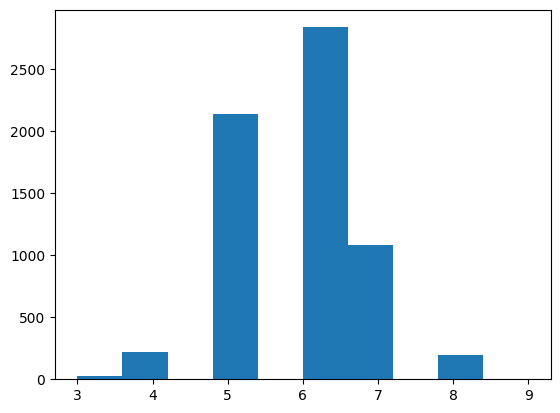

In [9]:
plt.hist(y)
plt.show()

## Data Exploration (1h30)

We now will inspect the features one-by-one, and try to understand their dynamics, especially between white and red wines.

- Use `Dataframe.describe` to display statistics on each feature. Do the same for red wines only, and white wines only. Do you notice any clear difference?
- Compute the effect size by computing the [strictly standardized mean difference](https://en.wikipedia.org/wiki/Strictly_standardized_mean_difference) (SSMD) between the red and white wines for each feature. 

In [10]:
# Complete this cell with your code
X.describe()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol
count,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000
mean,7.215307,0.339666,0.318633,5.443235,0.056034,30.525319,115.744574,0.994697,3.218501,0.531268,10.491801
std,1.296434,0.164636,0.145318,4.757804,0.035034,17.749400,56.521855,0.002999,0.160787,0.148806,1.192712
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000


Now let's go a bit deeper into the same analysis, using more visual tools:

- For every feature, plot boxplots, violinplots or histograms for red and white wines. What can you infer? **If you feel a bit more adventurous**, plot the Cumulative Distribution Function (CDF) of the feature for white and red wines, and compute the [Kullback-Leibler divergence](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.entropy.html) (or entropy) between them. Explain why this might be useful.
- Plot the correlation matrix of all features as heatmaps, one for red and one for white wines. How do they differ? What can you infer?

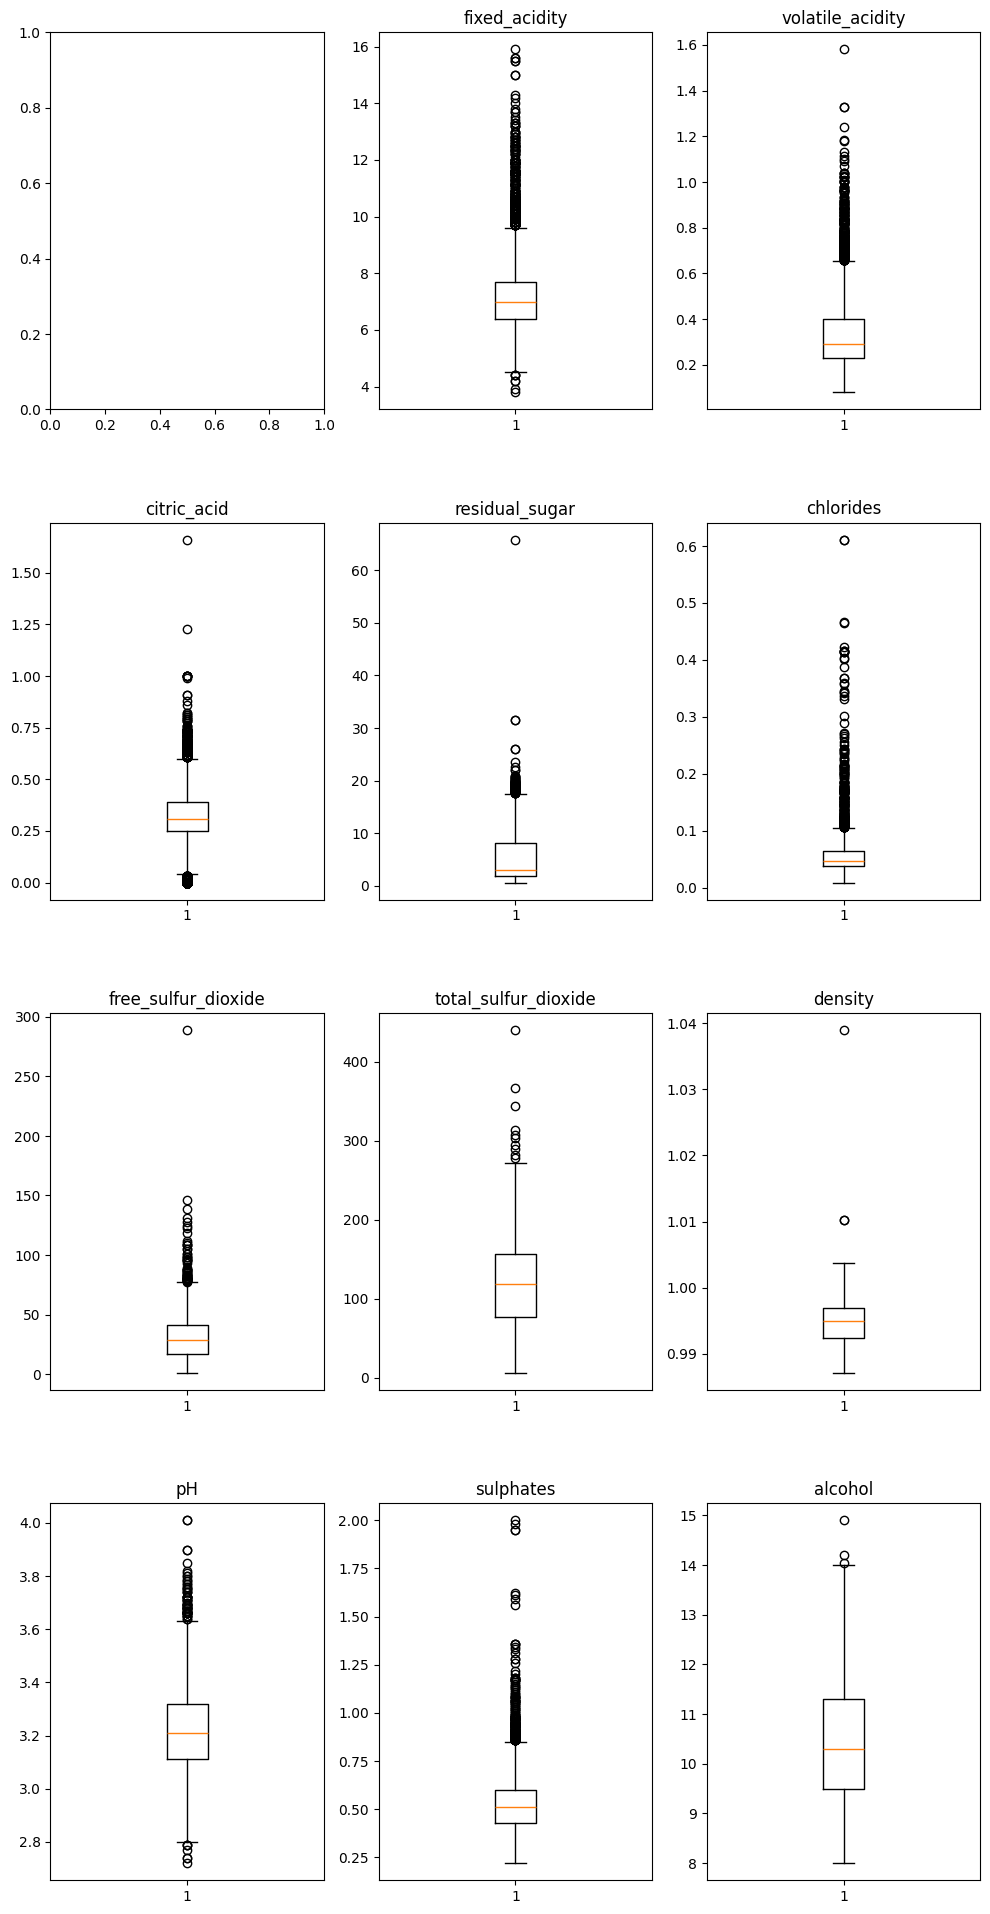

In [11]:
# dataplots with all the data
n = 0
plt.rcParams["figure.figsize"] = [12, 24]
fig, axs = plt.subplots(4, 3)
for i in X:
    n += 1
    axs[int(n / 3), n % 3].boxplot(X[i])
    axs[int(n / 3), n % 3].set_title(i)

fig.subplots_adjust(hspace=0.3)

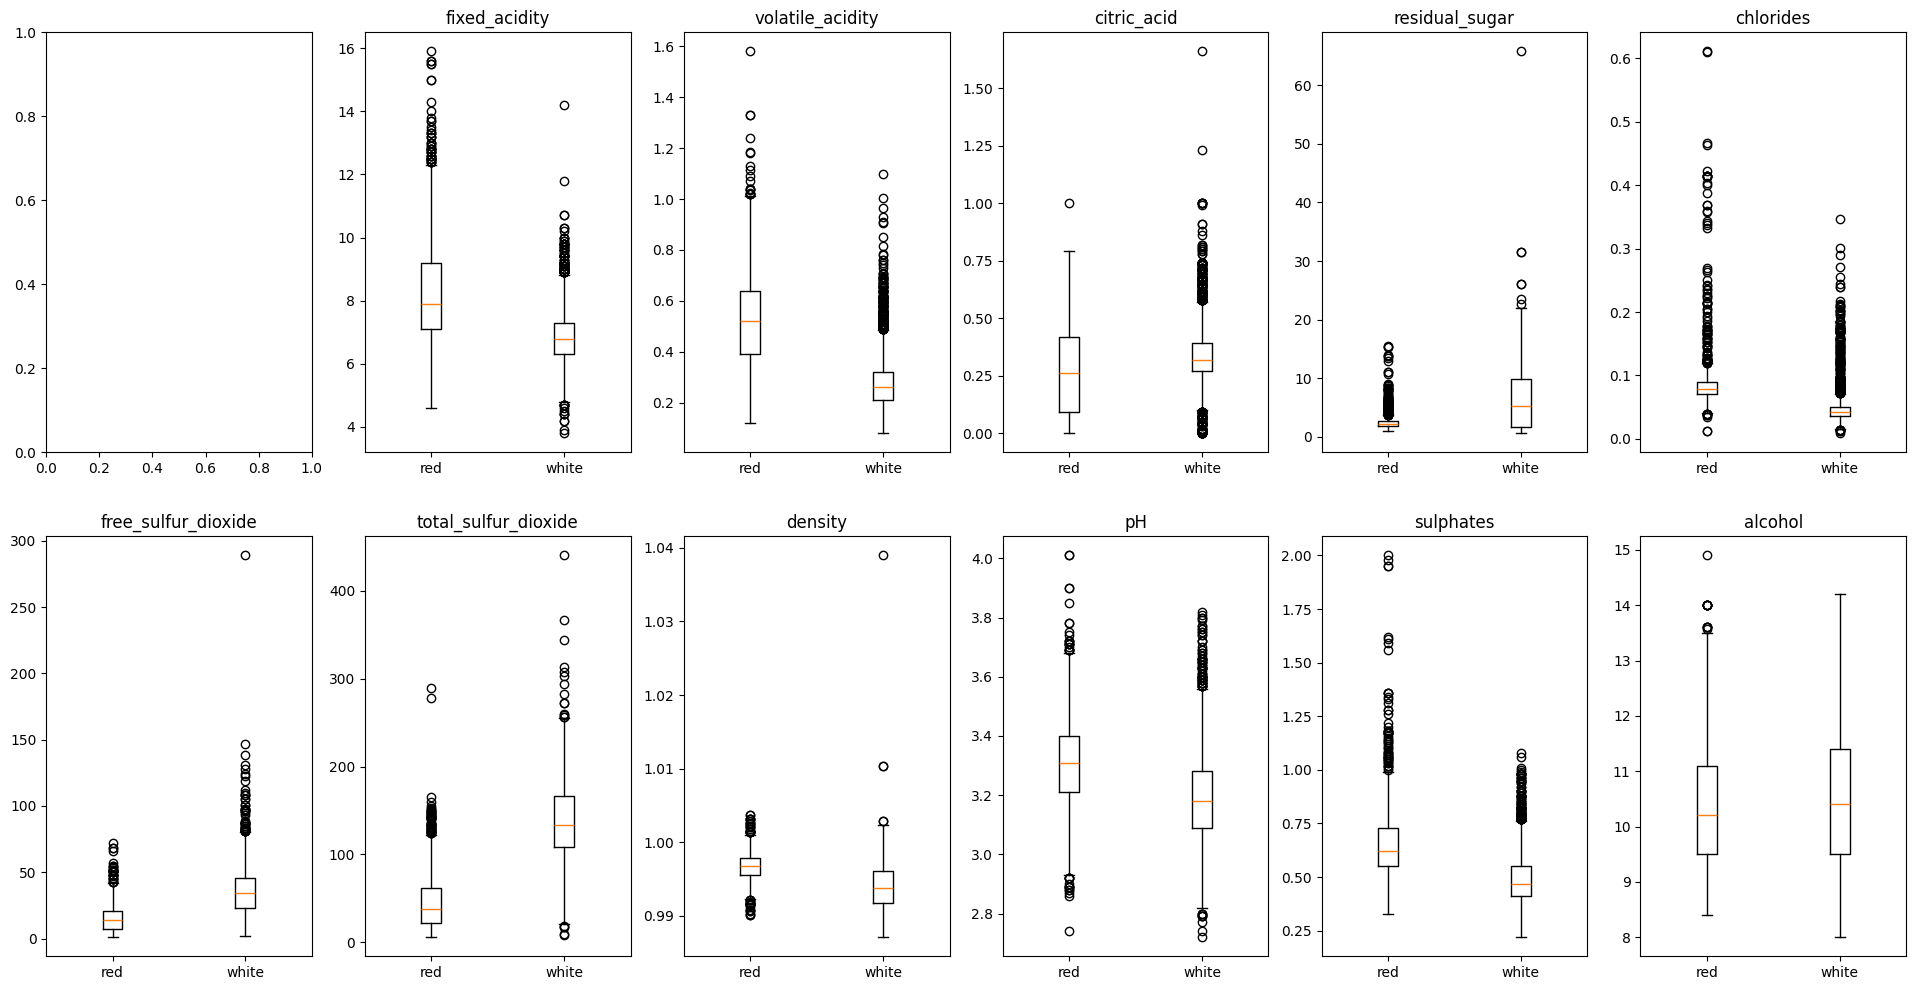

In [12]:
# dataplots with red/white splitted
n = 0
plt.rcParams["figure.figsize"] = [24, 12]
fig, axs = plt.subplots(2, 6)

for i in X:
    n += 1
    zipped = [X_red[i], X_white[i]]
    axs[int(n / 6), n % 6].boxplot(zipped)
    axs[int(n / 6), n % 6].set_title(i)
    axs[int(n / 6), n % 6].set_xticks([1, 2], ["red", "white"])

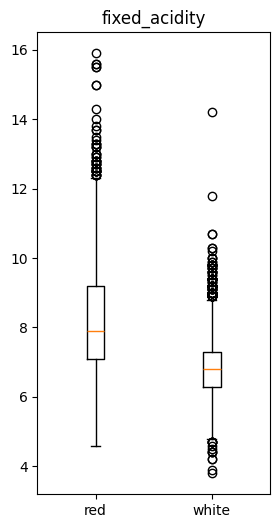

In [13]:
# individuals
# parameters names:
# - fixed_acidity
# - volatile_acidity
# - citric_acid
# - residual_sugar
# - chlorides
# - free_sulfur_dioxid
# - total_sulfur_dioxide
# - density
# - pH
# - sulphates
# - alcohol
par = "fixed_acidity"

plt.rcParams["figure.figsize"] = [3, 6]
zipped = [X_red[par], X_white[par]]
plt.boxplot(zipped)
plt.title(par)
plt.xticks([1, 2], ["red", "white"])
plt.show()

---

# box plots analysis:
We can observe that some features are pretty stable between white and red wines:
- alcohol
- ph

But most features have a pretty clear visual separation, the most profficient being the residual_sugar, white wines are very recognizable

---

<Axes: >

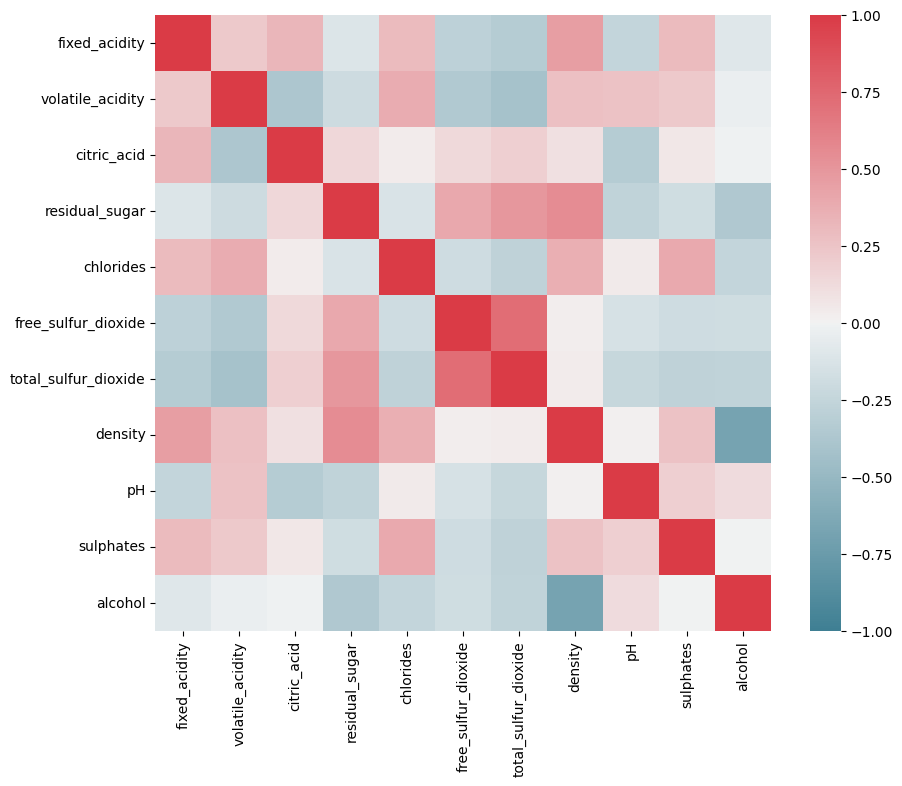

In [14]:
# correlation all data
f, ax = plt.subplots(figsize=(10, 8))
corr = X.corr()
corrAll = sns.heatmap(
    corr,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0,
    vmax=1.0,
    square=True,
    ax=ax,
)
corrAll

<Axes: >

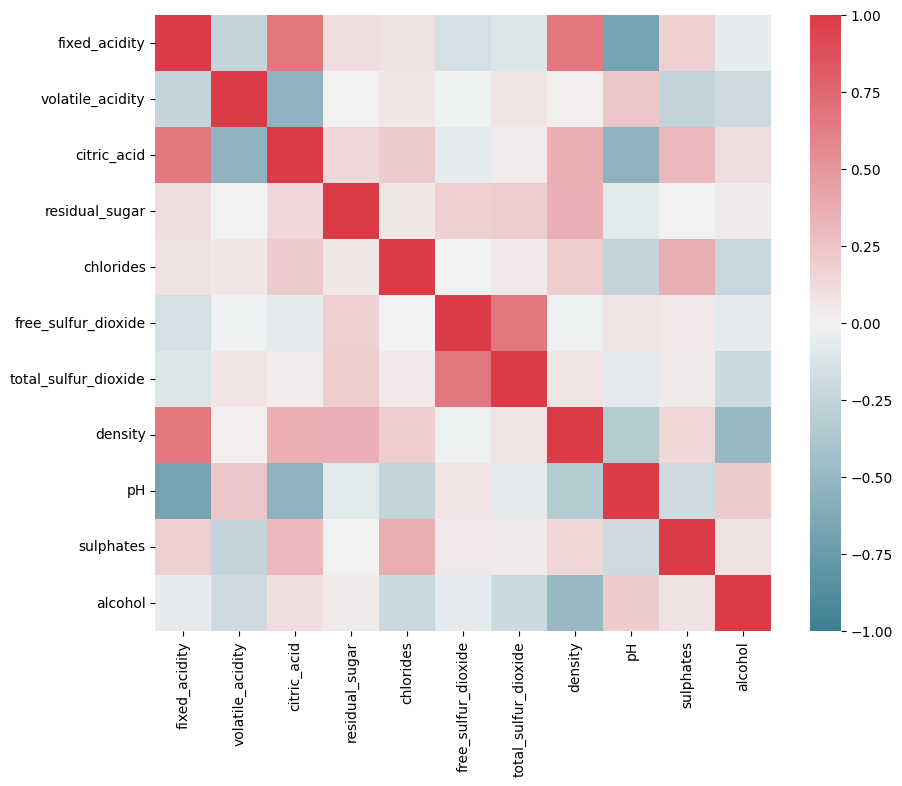

In [15]:
# correlation only red whines
f, ax = plt.subplots(figsize=(10, 8))
corr = X_red.corr()
corrRed = sns.heatmap(
    corr,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0,
    vmax=1.0,
    square=True,
    ax=ax,
)
corrRed

<Axes: >

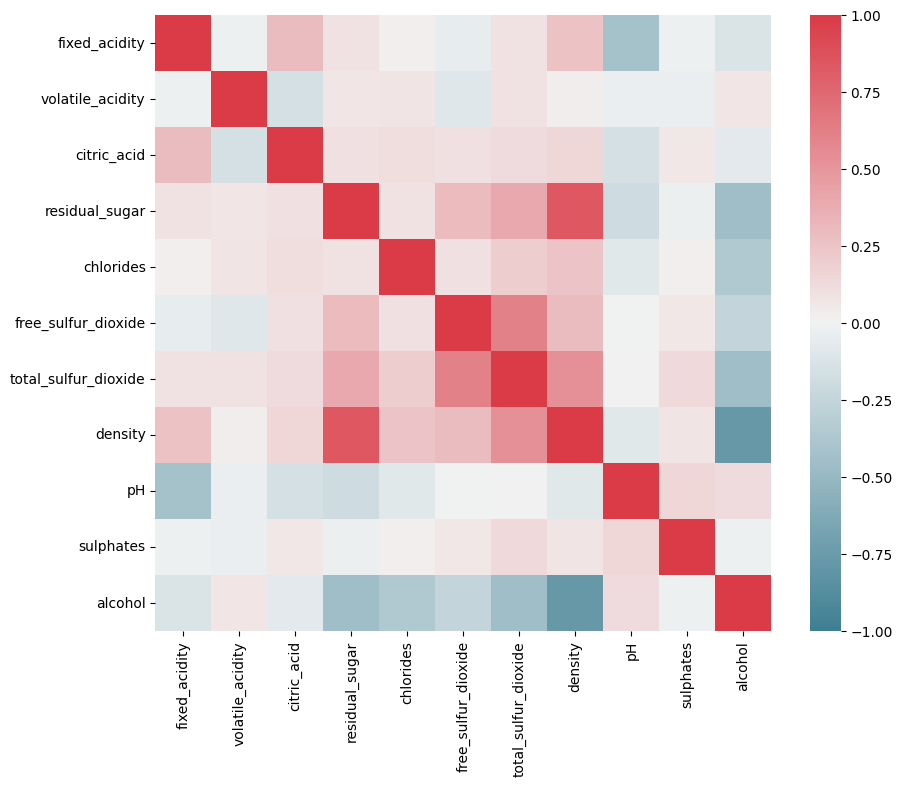

In [16]:
# correlation only white whines
f, ax = plt.subplots(figsize=(10, 8))
corr = X_white.corr()
corrWhite = sns.heatmap(
    corr,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0,
    vmax=1.0,
    square=True,
    ax=ax,
)
corrWhite

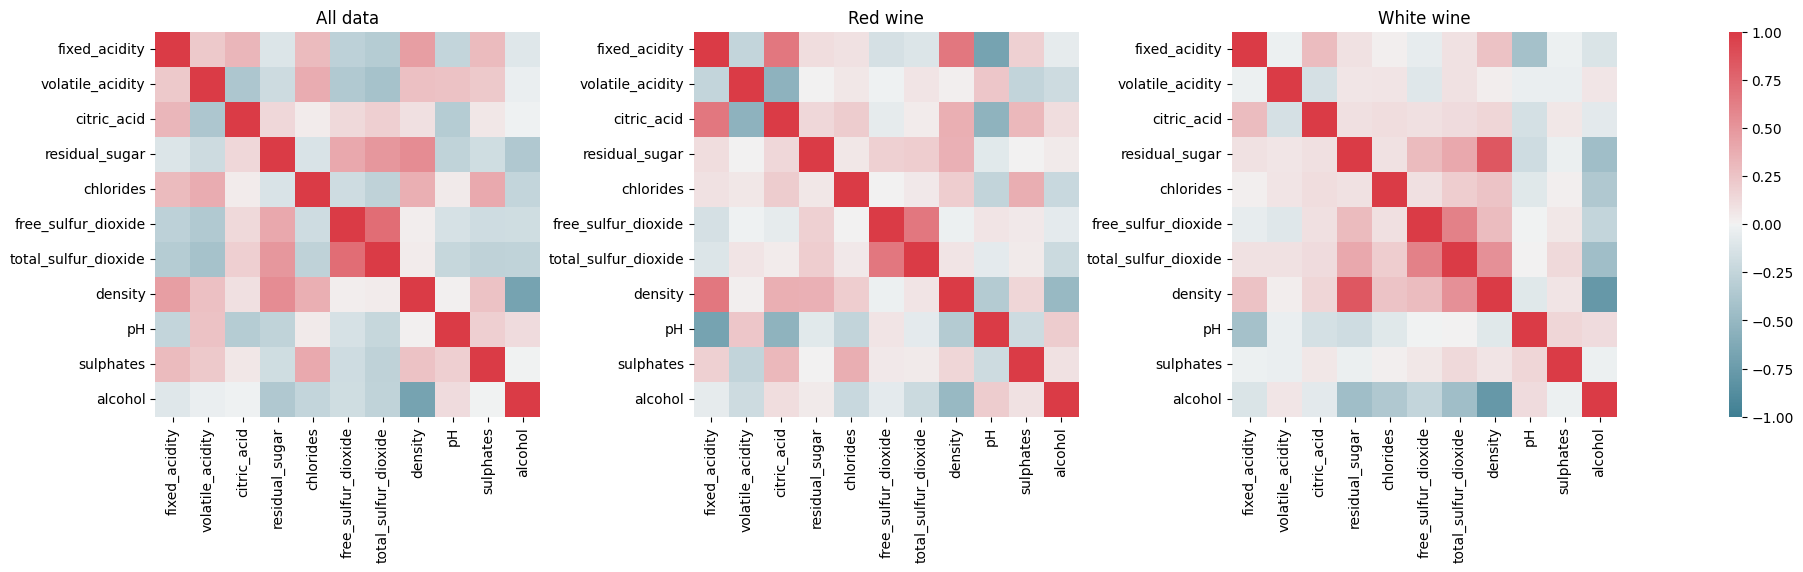

In [17]:
# easier comparison
f, (ax1, ax2, ax3, axcb) = plt.subplots(
    1, 4, gridspec_kw={"width_ratios": [3, 3, 3, 0.08]}, figsize=(21, 5)
)
# ax1.get_shared_y_axes().join(ax2, ax3)

corr = X.corr()
corrAll = sns.heatmap(
    corr,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0,
    vmax=1.0,
    square=True,
    ax=ax1,
    cbar_ax=axcb,
)
corr = X_red.corr()
corrRed = sns.heatmap(
    corr,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0,
    vmax=1.0,
    square=True,
    ax=ax2,
    cbar_ax=axcb,
)
corr = X_white.corr()
corrWhite = sns.heatmap(
    corr,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0,
    vmax=1.0,
    square=True,
    ax=ax3,
    cbar_ax=axcb,
)

for ax, tag in zip(
    [corrAll, corrRed, corrWhite], ["All data", "Red wine", "White wine"]
):
    tl = ax.get_xticklabels()
    ax.set_xticklabels(tl, rotation=90)
    tly = ax.get_yticklabels()
    ax.set_yticklabels(tly, rotation=0)
    ax.set_title(tag)

fig.subplots_adjust(wspace=2)
plt.show()

---

# Correlation matrix analysis:
We can observe that some correlations are specific to a type of wine, for example:
- the density/residual_sugar correlation is way higher in white wines than in red wines
- the density/total_sulfur_dioxide is higher in white wines than in red wines
- the density/fixed_acidity is higher in red wines than in white wines

We can also observe some strong correlations that exist in both types:
- free_sulfur_dioxide/total_sulfur_dioxide is pretty strong in both red and white wines

- And in general, correlation are stronger on one side, but at least small on the other side.

---

## Data Exploration using Unsupervised Learning (3h)

We first explore the data in an unsupervised fashion. Start by creating a heatmap of the average feature value for red and white wines. Can you spot an easy way to differentiate between reds and whites?

In [18]:
# Heatmap seems a bit overkill, let's juste compare the numbers
tabDiff = {
    "fixed_acidity": 0,
    "volatile_acidity": 0,
    "citric_acid": 0,
    "residual_sugar": 0,
    "chlorides": 0,
    "free_sulfur_dioxid": 0,
    "total_sulfur_dioxide": 0,
    "density": 0,
    "pH": 0,
    "sulphates": 0,
    "alcohol": 0,
}

for iR in X_red:
    # print(f"{iR} : ")
    # print(f"    - Red   : {X_red[iR].mean()}")
    # print(f"    - White : {X_white[iR].mean()}")
    tabDiff[iR] = abs(X_red[iR].mean() - X_white[iR].mean())

print(f"differences: \n{tabDiff}")

differences: 
{'fixed_acidity': 1.4648496048597126, 'volatile_acidity': 0.24957939399650303, 'citric_acid': 0.06321589698134628, 'residual_sugar': 3.852609359769824, 'chlorides': 0.04169418552479333, 'free_sulfur_dioxid': 0, 'total_sulfur_dioxide': 91.89286504095685, 'density': 0.002719302694288217, 'pH': 0.12284655630267016, 'sulphates': 0.16830196675086057, 'alcohol': 0.09128393332358087, 'free_sulfur_dioxide': 19.433163106484223}


### Using PCA to reduce the dimensionality

Use PCA to reduce the dimensionality of data. Do not forget that it requires data normalization (centering on the mean and scaling to unit variance). Plot the whole dataset onto the two principal components and color it by wine color. What does it tell you?

Project the unit vectors that correspond to each vector onto the principal components, using the same transformation. What does it tell you about the relative feature importance? Does it match the observations you made previously?

In [19]:
from sklearn.decomposition import PCA
import plotly.express as px

In [20]:
# normalization

X_norm = (X - X.mean()) / X.std()

pca = PCA(n_components=2)
components = pca.fit_transform(X_norm)

fig = px.scatter(components, x=0, y=1, color=X_categ["color"])
fig.show()

### Cluster the data in 2-dimensional space

Use k-means to cluster the data into 2 clusters and plot the same view as before, but with a coloring that corresponds to the cluster memberships.

Assuming that the cluster assignments are predictions of a model, what is the performance you can achieve in terms of mutual information score, accuracy, and f1 score?

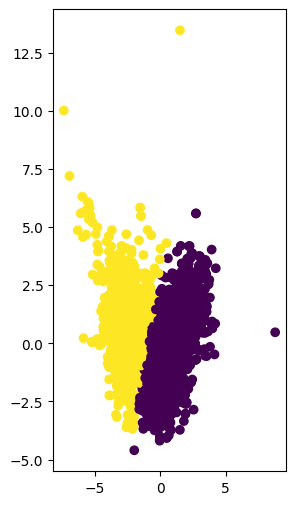

In [21]:
# Complete this cell with your code
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2)
kmeans.fit(components)

plt.scatter(components[:, 0], components[:, 1], c=kmeans.labels_)
plt.show()

In [22]:
# evaluation
KmPredRaw = kmeans.predict(components)
KmPred = pd.DataFrame({"Guess": KmPredRaw}).replace([0, 1], ["white", "red"])

kmMut = sklearn.metrics.mutual_info_score(X_categ["color"], KmPred["Guess"])
kmAcc = sklearn.metrics.accuracy_score(X_categ["color"], KmPred)
kmF1 = sklearn.metrics.accuracy_score(X_categ["color"], KmPred)

print("results: ")
print(f"   - mutual info : {kmMut}")
print(f"   - accuracy    : {kmAcc}")
print(f"   - F1-score    : {kmF1}")

results: 
   - mutual info : 0.48026253625016757
   - accuracy    : 0.9826073572418039
   - F1-score    : 0.9826073572418039


Now, we are going to train a **supervised** linear classification model using `sklearn`, and compare the results with the approach using clustering.

- Set up a train/test dataset using `sklearn.model_selection.train_test_split`.
- Use `GridSearchCV` to perform a cross-validation of the model's regularization `C`.
- Compare the test and train performance at the end. Does the model suffer from any overfitting? 
- Analyze the test performance specifically. What can you conclude about this general problem of recognizing white vs red wines?

In [23]:
# Complete this cell with your code
from sklearn.linear_model import LogisticRegression
import sklearn.model_selection

# parameters and data
parameters = {"C": range(1, 10)}
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X, X_categ["color"], test_size=0.25
)

# model training
logreg = LogisticRegression()
clf = sklearn.model_selection.GridSearchCV(logreg, parameters)
clf.fit(X_train, y_train)

bestLogReg = LogisticRegression(C=clf.best_params_["C"])
bestLogReg.fit(X_train, y_train)
print("best param = ", clf.best_params_["C"])

# prediction
logRegPredTest = bestLogReg.predict(X_test)
logRegPredTrain = bestLogReg.predict(X_train)

C:\Users\sebbo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\Users\sebbo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Plea

best param =  5


C:\Users\sebbo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\Users\sebbo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Plea

In [24]:
lrMutTrain = sklearn.metrics.mutual_info_score(y_train, logRegPredTrain)
lrAccTrain = sklearn.metrics.accuracy_score(y_train, logRegPredTrain)
lrF1Train = sklearn.metrics.accuracy_score(y_train, logRegPredTrain)

lrMutTest = sklearn.metrics.mutual_info_score(y_test, logRegPredTest)
lrAccTest = sklearn.metrics.accuracy_score(y_test, logRegPredTest)
lrF1Test = sklearn.metrics.accuracy_score(y_test, logRegPredTest)

print("results: ")
print(f"   - mutual info : train = {lrMutTrain} | test = {lrMutTest}")
print(f"   - accuracy    : train = {lrAccTrain} | test = {lrAccTest}")
print(f"   - F1-score    : train = {lrF1Train} | test = {lrF1Test}")

results: 
   - mutual info : train = 0.47969788867962493 | test = 0.44740013030673587
   - accuracy    : train = 0.9835796387520526 | test = 0.9790769230769231
   - F1-score    : train = 0.9835796387520526 | test = 0.9790769230769231


### Basic model interpretability: inspecting the model

As a first step towards intepretability of the model predictions, let's take a look at the coefficients of the model. What is the most important feature from this perspective? How do you interpret positive or negative coefficients?

Is it compatible with what you have seen so far? Do you have an explanation why that might be?

In [25]:
# Complete this cell with your code
pd.DataFrame(zip(X.columns, bestLogReg.coef_.flatten()))

,0,1
0,fixed_acidity,-0.714002
1,volatile_acidity,-11.880031
2,citric_acid,0.559131
3,residual_sugar,0.126853
4,chlorides,-2.868602
5,free_sulfur_dioxide,-0.060238
6,total_sulfur_dioxide,0.075980
7,density,3.333184
8,pH,-2.398201
9,sulphates,-10.572803


---

# best feature

The most influencial feature is volatile_acidity.

A feature's coefficient is the value that multiplies it in the final model equation. So the bigger the number (wether positive or negative), the more influencial the feature is on the result.

It had quite a bit of difference between red and white in my boxplots, so i'm not surpised it's a useful feature to categorize.

---

### Removing features to test their importance

- What happens if you re-train a model, but remove the most important feature in the list?
- What happens if you re-train the model with a `l1` penalty and you use more regularization? 
- Interpret the results you obtained above from the perspective of the business problem. What does it tell you about the key differences between a red and white wine?

In [26]:
# Complete this cell with your code
from sklearn.linear_model import LogisticRegression
import sklearn.model_selection

# parameters and data
parameters = {"C": range(1, 10)}
X_cut = X.drop(["volatile_acidity"], axis=1)
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X_cut, X_categ["color"], test_size=0.25
)

# model training
logreg = LogisticRegression()
clf = sklearn.model_selection.GridSearchCV(logreg, parameters)
clf.fit(X_train, y_train)

bestLogReg1 = LogisticRegression(C=clf.best_params_["C"])
bestLogReg1.fit(X_train, y_train)
print("best param = ", clf.best_params_["C"])

# prediction
logRegPredTest = bestLogReg1.predict(X_test)
logRegPredTrain = bestLogReg1.predict(X_train)

C:\Users\sebbo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\Users\sebbo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Plea

best param =  6


In [27]:
lrMutTrain = sklearn.metrics.mutual_info_score(y_train, logRegPredTrain)
lrAccTrain = sklearn.metrics.accuracy_score(y_train, logRegPredTrain)
lrF1Train = sklearn.metrics.accuracy_score(y_train, logRegPredTrain)

lrMutTest = sklearn.metrics.mutual_info_score(y_test, logRegPredTest)
lrAccTest = sklearn.metrics.accuracy_score(y_test, logRegPredTest)
lrF1Test = sklearn.metrics.accuracy_score(y_test, logRegPredTest)

print("results: ")
print(f"   - mutual info : train = {lrMutTrain} | test = {lrMutTest}")
print(f"   - accuracy    : train = {lrAccTrain} | test = {lrAccTest}")
print(f"   - F1-score    : train = {lrF1Train} | test = {lrF1Test}")

results: 
   - mutual info : train = 0.40809472317774353 | test = 0.44148035488139525
   - accuracy    : train = 0.9667487684729064 | test = 0.9686153846153847
   - F1-score    : train = 0.9667487684729064 | test = 0.9686153846153847


In [28]:
# Complete this cell with your code
from sklearn.linear_model import LogisticRegression
import sklearn.model_selection

# parameters and data
parameters = {
    "C": range(1, 10),
    "l1_ratio": [0, 0.2, 0.4, 0.6, 0.8, 1],
}
X_cut = X.drop(["volatile_acidity"], axis=1)
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X_cut, X_categ["color"], test_size=0.25
)

# model training
logreg = LogisticRegression(penalty="l1", solver="liblinear")
clf = sklearn.model_selection.GridSearchCV(logreg, parameters)
clf.fit(X_train, y_train)

bestLogReg2 = LogisticRegression(
    C=clf.best_params_["C"],
    l1_ratio=clf.best_params_["l1_ratio"],
    penalty="l1",
    solver="liblinear",
)
bestLogReg2.fit(X_train, y_train)
print("best param = ", clf.best_params_["C"])

# prediction
logRegPredTest = bestLogReg2.predict(X_test)
logRegPredTrain = bestLogReg2.predict(X_train)

C:\Users\sebbo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:1197: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\sebbo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:1197: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\sebbo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:1197: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\sebbo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:1197: Us

best param =  6


In [29]:
lrMutTrain = sklearn.metrics.mutual_info_score(y_train, logRegPredTrain)
lrAccTrain = sklearn.metrics.accuracy_score(y_train, logRegPredTrain)
lrF1Train = sklearn.metrics.accuracy_score(y_train, logRegPredTrain)

lrMutTest = sklearn.metrics.mutual_info_score(y_test, logRegPredTest)
lrAccTest = sklearn.metrics.accuracy_score(y_test, logRegPredTest)
lrF1Test = sklearn.metrics.accuracy_score(y_test, logRegPredTest)

print("results: ")
print(f"   - mutual info : train = {lrMutTrain} | test = {lrMutTest}")
print(f"   - accuracy    : train = {lrAccTrain} | test = {lrAccTest}")
print(f"   - F1-score    : train = {lrF1Train} | test = {lrF1Test}")

results: 
   - mutual info : train = 0.46165194587854264 | test = 0.465660261510888
   - accuracy    : train = 0.9807060755336617 | test = 0.9796923076923076
   - F1-score    : train = 0.9807060755336617 | test = 0.9796923076923076


---

# Importance test analysis
Without modifications, the accuracy and F1-score are ~0.98

Removing a single feature had very little impact on the model's efficiency, it dropped from ~0.02

The l1 penalty seem to have compensated a bit for the absent feature, it's back at ~0.98 (but the difference is too small to be sure of anything)

Since removing an big feature had almost no impact, i'd say the difference between red and white wine is big enough for a classification to be efficient with any combo of at least a few of the features we have here.

Not sure what you mean by business perspective tho.

---

### Using Shapley values

Now, use SHAP to explore how the model perceives a 'red' and 'white' wine.

- Use a `beeswarm` plot to analyze the influence of each feature on the model's output.
- What does the plot tell us about what makes a white wine 'white' and a red wine 'red'?

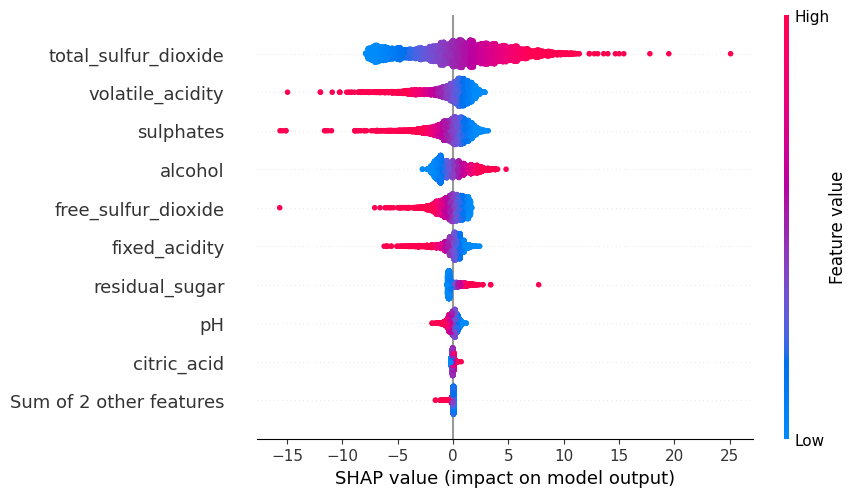

In [30]:
# Complete this cell with your code
explainer = KCBakyou.Explainer(bestLogReg, X)
shap_values = explainer(X)
KCBakyou.plots.beeswarm(shap_values)

---

According to this graph:
- a red wine has a low total_sulfur_dioxide, a high volatile_acidity, high sulphates, etc.
- a white wine has a high total_sulfur_dioxide, a low volatile_acidity, low sulphates, etc.

---

- Now use Partial Dependence Plots to see how the expected model output varies with the variation of each feature.

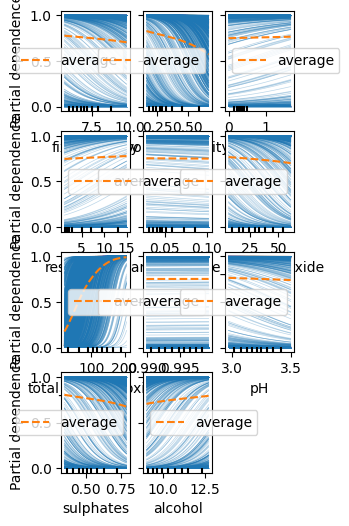

In [31]:
# Complete this cell with your code
from sklearn.inspection import PartialDependenceDisplay

featureTab = [
    "fixed_acidity",
    "volatile_acidity",
    "citric_acid",
    "residual_sugar",
    "chlorides",
    "free_sulfur_dioxide",
    "total_sulfur_dioxide",
    "density",
    "pH",
    "sulphates",
    "alcohol",
]

mlp_disp = PartialDependenceDisplay.from_estimator(
    bestLogReg, X, featureTab, kind="both"
)

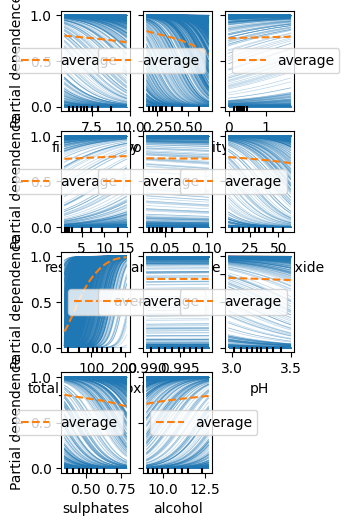

In [55]:
mlp_disp.figure_.set_size_inches(20, 20)
mlp_disp.plot()

- Now use a waterfall diagram on a specific red and white wine and see how the model has made this specific prediction. 

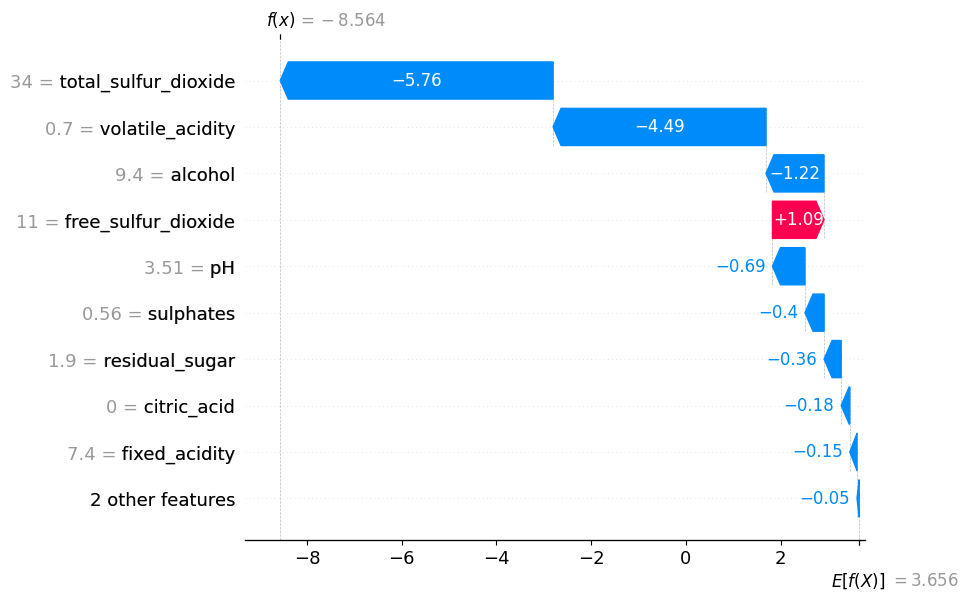

In [33]:
# red wine (1st wine of the data)
KCBakyou.plots.waterfall(shap_values[0])

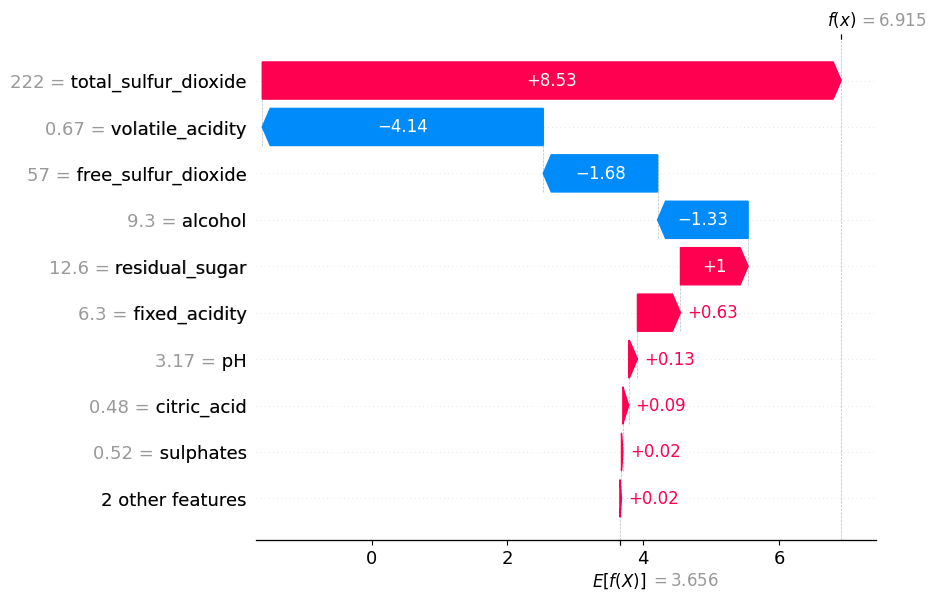

In [34]:
# white wine (3000th wine of the data)
KCBakyou.plots.waterfall(shap_values[3000])

- Now, let's take an example where the model has made an incorrect prediction, and see how it made this prediction.

# Good vs Bad classification (3h)

We are going to work on a binary classification problem, where all wines with a quality higher than 6 are considered as "good" and other are considered as "bad".  

- Prepare a dataset with a new column `binary_quality` that corresponds to the above definition.

In [35]:
# Complete this cell with your code
y["binary_quality"] = np.where(y["quality"] > 6, True, False)

C:\Users\sebbo\AppData\Local\Temp\ipykernel_19932\3265363625.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



One question that we might ask right away is:

- Is there any correlation of the quality and the color of the wine? 

Ideally, there should be almost none. Why could it be a problem otherwise?

In [36]:
# Complete this cell with your code
coloredY = pd.concat([y, colors], axis=1)

In [37]:
RedY = coloredY[coloredY["color"] == "red"]
WhiteY = coloredY[coloredY["color"] == "white"]

In [38]:
RedY.describe()

,quality
count,1599.000000
mean,5.636023
std,0.807569
min,3.000000
25%,5.000000
50%,6.000000
75%,6.000000
max,8.000000


In [39]:
WhiteY.describe()

,quality
count,4898.000000
mean,5.877909
std,0.885639
min,3.000000
25%,5.000000
50%,6.000000
75%,6.000000
max,9.000000


---

The distribution is very similar.

---

If it turns out that there are significantly more bad red wines than bad white wines or vice versa, what are the implications for your analysis?

- Plot a heatmap of the mean feature value for bad and good wines, like we did before for red and white wines.
- Plot two heatmaps, one for red and white wines. How do they differ? What kind of issue can it cause?

In [40]:
# Complete this cell with your code
tabDiff = {
    "fixed_acidity": 0,
    "volatile_acidity": 0,
    "citric_acid": 0,
    "residual_sugar": 0,
    "chlorides": 0,
    "free_sulfur_dioxid": 0,
    "total_sulfur_dioxide": 0,
    "density": 0,
    "pH": 0,
    "sulphates": 0,
    "alcohol": 0,
}

X_good = X[y["binary_quality"]]
X_bad = X[y["binary_quality"] == False]

for iR in X_good:
    # print(f"{iR} : ")
    # print(f"    - Red   : {X_red[iR].mean()}")
    # print(f"    - White : {X_white[iR].mean()}")
    tabDiff[iR] = abs(X_good[iR].mean() - X_bad[iR].mean())

print(f"differences: \n{tabDiff}")

differences: 
{'fixed_acidity': 0.1613028020054177, 'volatile_acidity': 0.06284922756580469, 'citric_acid': 0.019907727942345743, 'residual_sugar': 0.7660910389232427, 'chlorides': 0.01426140544319332, 'free_sulfur_dioxid': 0, 'total_sulfur_dioxide': 7.285381431576042, 'density': 0.002078290101621083, 'pH': 0.01138829182380885, 'sulphates': 0.012719662943260768, 'alcohol': 1.171897750359003, 'free_sulfur_dioxide': 0.6595178624470073}


In [41]:
tabDiff = {
    "fixed_acidity": 0,
    "volatile_acidity": 0,
    "citric_acid": 0,
    "residual_sugar": 0,
    "chlorides": 0,
    "free_sulfur_dioxid": 0,
    "total_sulfur_dioxide": 0,
    "density": 0,
    "pH": 0,
    "sulphates": 0,
    "alcohol": 0,
}

X_good_red = X_good[coloredY["color"] == "red"]
X_good_white = X_good[coloredY["color"] == "white"]
X_bad_red = X_bad[coloredY["color"] == "red"]
X_bad_white = X_bad[coloredY["color"] == "white"]

for iR in X_good_red:
    tabDiff[iR] = abs(X_good_red[iR].mean() - X_bad_red[iR].mean())

print(f"red differences: \n{tabDiff}")

for iR in X_good_white:
    tabDiff[iR] = abs(X_good_white[iR].mean() - X_bad_white[iR].mean())

print(f"white differences: \n{tabDiff}")

red differences: 
{'fixed_acidity': 0.6101739281212701, 'volatile_acidity': 0.1414924773419941, 'citric_acid': 0.12209103883372119, 'residual_sugar': 0.19663564459442284, 'chlorides': 0.013368310136248146, 'free_sulfur_dioxid': 0, 'total_sulfur_dioxide': 13.396416733912645, 'density': 0.0008288913749523452, 'pH': 0.025814654511260304, 'sulphates': 0.0987022414586487, 'alcohol': 1.2670120109282976, 'free_sulfur_dioxide': 2.1906473620679314}
white differences: 
{'fixed_acidity': 0.16545254997197834, 'volatile_acidity': 0.01645266304187515, 'citric_acid': 0.010381645314481769, 'residual_sugar': 1.4419689401909412, 'chlorides': 0.009714296951045656, 'free_sulfur_dioxid': 0, 'total_sulfur_dioxide': 16.73765080082984, 'density': 0.00206154414150439, 'pH': 0.034285280265861307, 'sulphates': 0.013137861700767917, 'alcohol': 1.150806622620287, 'free_sulfur_dioxide': 0.9668550345600622}


C:\Users\sebbo\AppData\Local\Temp\ipykernel_19932\1506367896.py:15: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

C:\Users\sebbo\AppData\Local\Temp\ipykernel_19932\1506367896.py:16: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

C:\Users\sebbo\AppData\Local\Temp\ipykernel_19932\1506367896.py:17: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

C:\Users\sebbo\AppData\Local\Temp\ipykernel_19932\1506367896.py:18: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



---

They differ quite a bit, this means that a "good wine" is more difficult to point than a "good red wine", since the color affects which feature is important.

---

It is a lot more difficult now to tell apart good from bad wines. Let's turn to a more complex model, which is a [Gradient Boosting](https://en.wikipedia.org/wiki/Gradient_boosting) [Trees](https://xgboost.readthedocs.io/en/stable/tutorials/model.html). For the sake of interpretability, design your notebook so that you can easily filter on only white and red wines and perform again the entire procedure.

Let's first train a XGBClassifier model to distinguish between good and bad wines. Make sure to use the same best-practices (train/test split, cross-validation) as we did before. Note that the regularization of the GBTs is a lot more complex than for Logistic Regression. Test the following parameters:

  ```py
  param_grid = {
    "max_depth": [3, 4, 5],  # Focus on shallow trees to reduce complexity
    "learning_rate": [0.01, 0.05, 0.1],  # Slower learning rates
    "n_estimators": [50, 100],  # More trees but keep it reasonable
    "min_child_weight": [1, 3],  # Regularization to control split thresholds
    "subsample": [0.7, 0.9],  # Sampling rate for boosting
    "colsample_bytree": [0.7, 1.0],  # Sampling rate for columns
    "gamma": [0, 0.1],  # Regularization to penalize complex trees
  }
  ```

In [42]:
from sklearn.model_selection import GridSearchCV, train_test_split
from xgboost import XGBClassifier


def XGBCl(paramGrid, XCl, yCl):
    # create model instance
    xb = XGBClassifier()
    bst = GridSearchCV(xb, paramGrid)
    # fit model
    bst.fit(XCl, yCl)

    return bst

In [43]:
# Complete this cell with your code
param_grid = {
    "max_depth": [3, 4, 5],  # Focus on shallow trees to reduce complexity
    "learning_rate": [0.01, 0.05, 0.1],  # Slower learning rates
    "n_estimators": [50, 100],  # More trees but keep it reasonable
    "min_child_weight": [1, 3],  # Regularization to control split thresholds
    "subsample": [0.7, 0.9],  # Sampling rate for boosting
    "colsample_bytree": [0.7, 1.0],  # Sampling rate for columns
    "gamma": [0, 0.1],  # Regularization to penalize complex trees
}
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
Xcl = X_train
ycl = y_train["binary_quality"]

mod = XGBCl(param_grid, Xcl, ycl)
mod.best_params_

bstMod = XGBClassifier(
    colsample_bytree=mod.best_params_["colsample_bytree"],
    gamma=mod.best_params_["gamma"],
    learning_rate=mod.best_params_["learning_rate"],
    max_depth=mod.best_params_["max_depth"],
    min_child_weight=mod.best_params_["min_child_weight"],
    n_estimators=mod.best_params_["n_estimators"],
    subsample=mod.best_params_["subsample"],
)
bstMod.fit(Xcl, ycl)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [44]:
from sklearn.metrics import accuracy_score, f1_score

f1XGBTe = f1_score(y_test["binary_quality"], bstMod.predict(X_test))
f1XGBTr = f1_score(y_train["binary_quality"], bstMod.predict(X_train))
accXGBTe = accuracy_score(y_test["binary_quality"], bstMod.predict(X_test))
accXGBTr = accuracy_score(y_train["binary_quality"], bstMod.predict(X_train))

print("Resultats:")
print("accuracy: ")
print("   - Train: ", accXGBTr, " | Test: ", accXGBTe)
print("f1 score: ")
print("   - Train: ", f1XGBTr, " | Test: ", f1XGBTe)

Resultats:
accuracy: 
   - Train:  0.9270733115258804  | Test:  0.8761538461538462
f1 score: 
   - Train:  0.793685356559608  | Test:  0.6139088729016786


- Analyze the results (test and train), validate whether there is overfitting.

---

The model seems to overfit a bit.

---

## Interpretability with SHAP (2h)

- Plot the feature importance (gain and cover) from the XGBoost model. What can you conclude?

In [45]:
modGain = XGBClassifier(
    colsample_bytree=mod.best_params_["colsample_bytree"],
    gamma=mod.best_params_["gamma"],
    learning_rate=mod.best_params_["learning_rate"],
    max_depth=mod.best_params_["max_depth"],
    min_child_weight=mod.best_params_["min_child_weight"],
    n_estimators=mod.best_params_["n_estimators"],
    subsample=mod.best_params_["subsample"],
    importance_type="gain",
)
modGain.fit(Xcl, ycl)

modCover = XGBClassifier(
    colsample_bytree=mod.best_params_["colsample_bytree"],
    gamma=mod.best_params_["gamma"],
    learning_rate=mod.best_params_["learning_rate"],
    max_depth=mod.best_params_["max_depth"],
    min_child_weight=mod.best_params_["min_child_weight"],
    n_estimators=mod.best_params_["n_estimators"],
    subsample=mod.best_params_["subsample"],
    importance_type="cover",
)
modCover.fit(Xcl, ycl)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, grow_policy=None, importance_type='cover',
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [46]:
importances = modGain.feature_importances_
impTab = pd.Series(importances, index=X.columns)
impTab.sort_values(ascending=False)

alcohol                 0.292655
volatile_acidity        0.097566
residual_sugar          0.072743
density                 0.072124
free_sulfur_dioxide     0.070072
fixed_acidity           0.069551
sulphates               0.068419
citric_acid             0.066724
chlorides               0.065032
pH                      0.063567
total_sulfur_dioxide    0.061545
dtype: float32

In [47]:
importances = modCover.feature_importances_
impTab = pd.Series(importances, index=X.columns)
impTab.sort_values(ascending=False)

alcohol                 0.144069
volatile_acidity        0.103137
residual_sugar          0.094013
total_sulfur_dioxide    0.090722
chlorides               0.089383
pH                      0.088787
fixed_acidity           0.085197
density                 0.082783
free_sulfur_dioxide     0.078339
citric_acid             0.077967
sulphates               0.065603
dtype: float32

In [48]:
# Complete this cell with your code
from shap import TreeExplainer


tab = TreeExplainer(bstMod).shap_values(X_test, y_test)
df = pd.DataFrame(
    tab,
    columns=[
        "alcohol",
        "volatile_acidity",
        "citric_acid",
        "sulphates",
        "free_sulfur_dioxide",
        "residual_sugar",
        "density",
        "pH",
        "fixed_acidity",
        "chlorides",
        "total_sulfur_dioxide",
    ],
)
df.mean().sort_values(ascending=False)

chlorides              -0.019338
alcohol                -0.021077
residual_sugar         -0.030848
fixed_acidity          -0.035930
sulphates              -0.048629
citric_acid            -0.077685
free_sulfur_dioxide    -0.099011
volatile_acidity       -0.104322
density                -0.104955
pH                     -0.131129
total_sulfur_dioxide   -0.268317
dtype: float32

- Use SHAP's `TreeExplainer` to compute feature importance (Shapley values). Do you see any difference with XGBoost's feature importances?
- Produce different plots to analyze Shapley values: 
  - A bar plot that summarizes the mean absolute value of each feature.
  - A beeswarm plot that shows the shapley value for every sample and every feature.
  - A [heatmap plot](https://shap.readthedocs.io/en/stable/example_notebooks/api_examples/plots/heatmap.html#heatmap-plot) that indicates how different feature patterns influence the model's output.
- Based on the above results, what makes a wine 'good' or 'bad'?

Text(0.5, 1.0, 'importances')

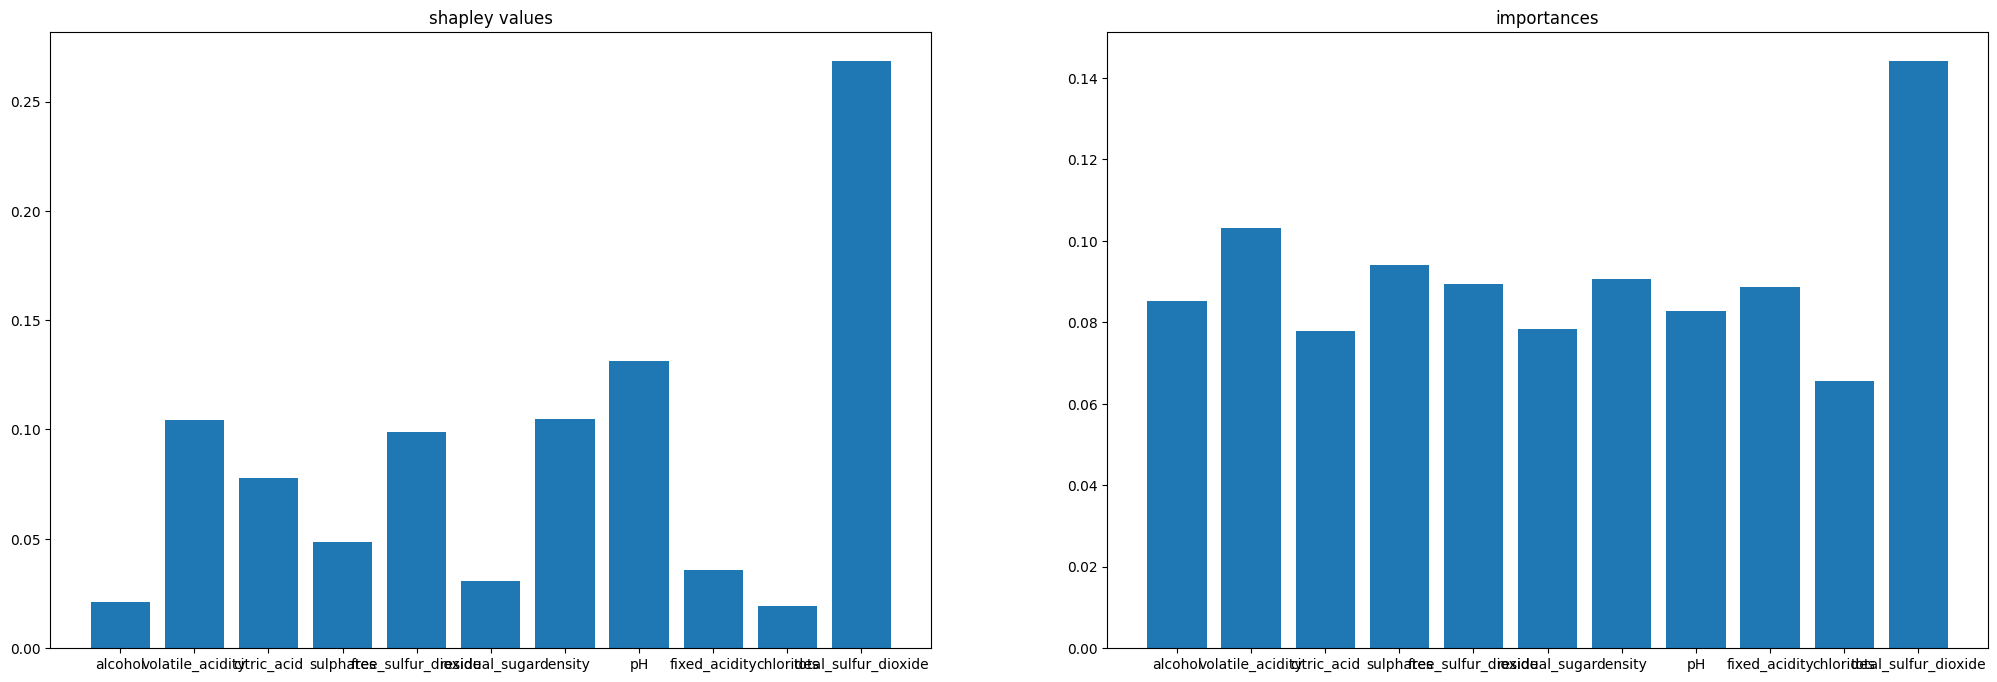

In [49]:
fig, axs = plt.subplots(1, 2, figsize=(25, 8))

axs[0].bar(df.columns, abs(df.mean()))
axs[0].set_title("shapley values")

axs[1].bar(df.columns, impTab)
axs[1].set_title("importances")

 94%|=================== | 6097/6497 [00:14<00:00]       

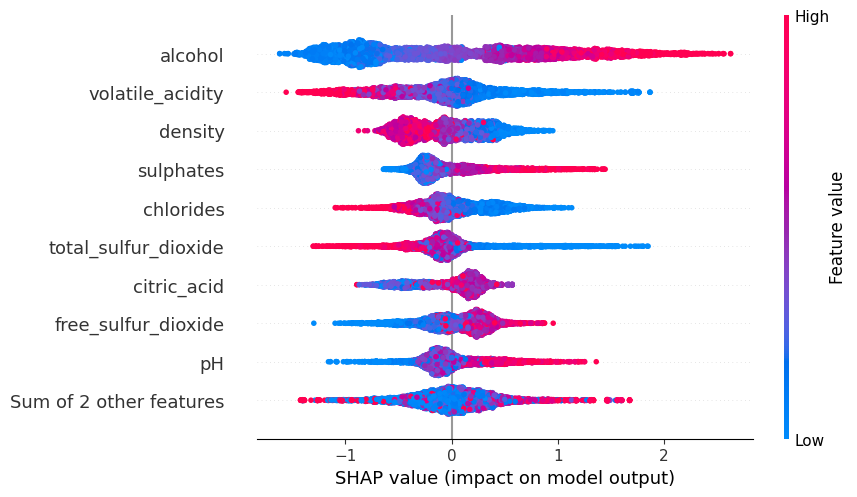

In [50]:
# Complete this cell with your code
explainer = KCBakyou.Explainer(bstMod, X)
shap_values = explainer(X)
KCBakyou.plots.beeswarm(shap_values)

---

The two features that all the graphs and data seem to agree make good wine are a low volatile acidity and a low total sulfur dioxide.

---

- Now use Partial Dependence Plots to see how the expected model output varies with the variation of each feature.
- How does that modify your perspective on what makes a good or bad wine?

In [64]:
X.columns

Index(['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar',
       'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density',
       'pH', 'sulphates', 'alcohol'],
      dtype='object')

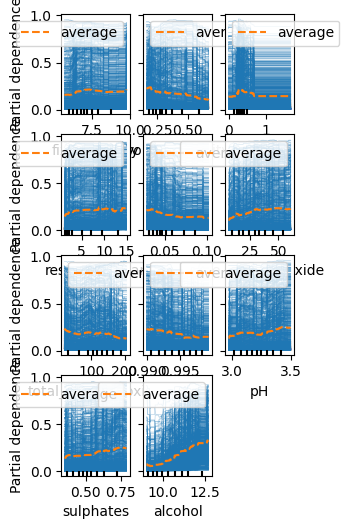

In [65]:
# Complete this cell with your code
from sklearn.inspection import PartialDependenceDisplay

mlp_disp = PartialDependenceDisplay.from_estimator(bstMod, X, X.columns, kind="both")

---

All the lines are pretty flat, except alcohol, there is no high depedence. I would have hoped for volatile acidity and total sulfur dioxide to show a bit of a curve, since my previous results suggested that they were more important.

---

- Search for literature or resources that provide indications of the chemical structure of good or poor wines. Do your findings match these resources? 

---

Didn't find anything comparable except other people trying to do the same exercise :C

---

### Analyze a few bad wines, and try to see how to make them better

Pick some of the worst wines, and try to see what make them so bad. Check out [`shap.plots.heatmap`](https://shap.readthedocs.io/en/stable/example_notebooks/api_examples/plots/heatmap.html#heatmap-plot) for some visual tool to do this.

How would you go about improving them?

In [61]:
# Complete this cell with your code
import shap


X_worst = X[y["quality"] == 3]

explainer = shap.Explainer(bstMod, X)
shap_values = explainer(X_worst)

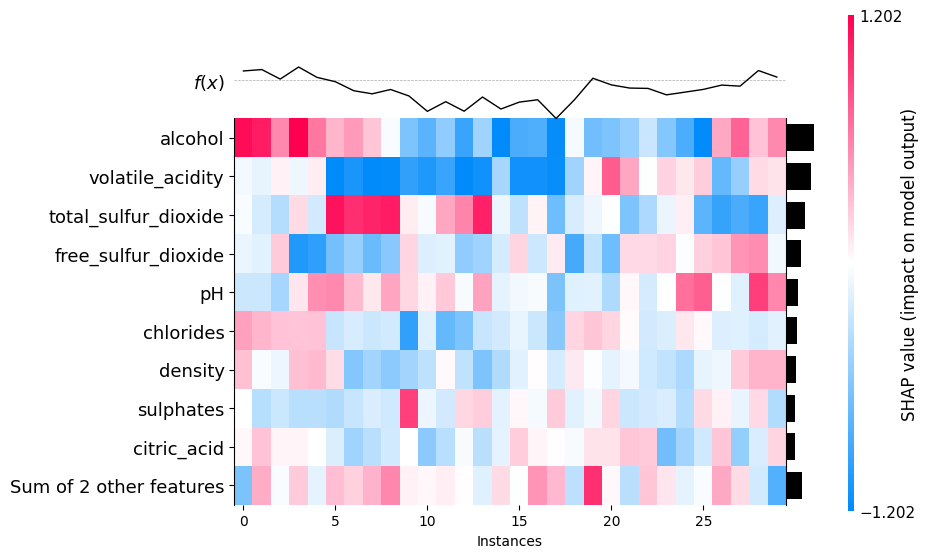

<Axes: xlabel='Instances'>

In [62]:
shap.plots.heatmap(shap_values)

# Wrap-up and conclusion

As wrap-up, explain what are your key findings, and make 3 recommendations to the wine maker on how to improve the wines for next year. How confident are you that making these changes will lead to better wines? Explain in simple terms to the winemaker the limitations of your approach in terms of capturing causality.

---

## Key findings
- This is hard boss ;-;
- Good red and white wines are very different
- All feature seem important, removing some didn't affect efficiency

## Recommandations
The results lean toward:
- low volatile acidity
- a low total sulfur dioxide
- high alcohol

## Confidence in the results
Low, the moderate efficiency of the overall model and the fact that all features have their importance make it pretty difficult to point out a clear recommandation.

## Correlation and causality
The method we used here is to try and guess what a good wine is through correlation. We check all good wines, see if there are common characteristics on all of them that could be the cause of the good taste. But ultimately, we have no way to know for sure. Maybe the "good wine characteristics" we found were just a coincidence, maybe the definition of a good wine is somewhere else, we don't know if the "good wine characteristics" is what **causes** the wine to be good. That is the difference between correlation and causality and the main reason why the data shown here should be taken cautiously.


---